# Task 1 - Exploratory Data Analysis

This notebook will walk you through this task interactively, meaning that once you've imported this notebook into `Google Colab`, you'll be able to run individual cells of code independantly, and see the results as you go.

This notebooks is designed for users that have an understanding of Python and data analysis. There will be some helper functions and initial setup code provided, but it will be up to you to perform the analysis and to draw insights!

---

## Section 1 - Imports


In [26]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from scipy import stats

In [27]:
def summaryStats(X,feature_list):
    q1 = X[feature_list].quantile(0.25)
    q3 = X[feature_list].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             null_values = X[feature_list].isnull().sum(),
                             lower_bound = fence_low,
                             upper_bound = fence_high,
                             outliers_from_IQR = ((X[feature_list] < fence_low) | (X[feature_list] > fence_high)).sum(),
                             outliers_from_Zscore = (np.abs(stats.zscore(X[feature_list])) > 3).sum()
                            ))
    return temp

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def target_by_cats(X):
    '''
    This function assumes the input dataframe (X) has a numerically defined target
    variable in the first column and that all remaining features are categorical
    '''
    global_mean = X.iloc[:,0].mean()
    target = X.columns[0]
    for col in X.columns[1:]:
        df_group = X.groupby(by=col)[target].agg(['mean']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        df_group['%diff'] = (df_group['diff']/df_group['mean'])*100
        display(df_group)

def trainTestMetrics(X_train,X_test,y_train,y_test,model):
    names=['R2','Adj-R2','MAE','MAPE','SSE'] 
    
    # Training Metrics
    y_hat = model.predict(X_train)
    
    # Create R2
    r2 = r2_score(y_train,y_hat).round(3)
    
    # Create adj_R2
    adj_r2 = (1-(1-r2_score(y_train,y_hat))*(len(y_train)-1)/(len(y_train)-len(model.coef_)-1)).round(3)

    
    train_metrics = [r2, adj_r2,
                     mean_absolute_error(y_train,y_hat).round(3),
                     mean_absolute_percentage_error(y_train,y_hat).round(3)*100,
                     (mean_squared_error(y_train,y_hat)*len(y_train)).round(3)
                    ]
    train_metrics = pd.DataFrame({'Train':train_metrics},index=names)
    
    # Testing Metrics
    y_hat = model.predict(X_test)
    test_metrics = [r2_score(y_test,y_hat).round(3),
                    (1-(1-r2_score(y_test,y_hat))*(len(y_test)-1)/(len(y_test)-len(model.coef_)-1)).round(3),
                    mean_absolute_error(y_test,y_hat).round(3),
                    mean_absolute_percentage_error(y_test,y_hat).round(3)*100,
                    (mean_squared_error(y_test,y_hat)*len(y_test)).round(3)
                   ]
    test_metrics = pd.DataFrame({'Test':test_metrics},index=names)
    
    all_metrics = train_metrics.merge(test_metrics,left_index=True,right_index=True)
    print(all_metrics)

---

## Section 2 - Data loading

Now that Google Drive is mounted, you can store the CSV file anywhere in your Drive and update the `path` variable below to access it within this notebook. Once we've updated the `path`, let's read this CSV file into a pandas dataframe and see what it looks like

In [28]:
df = pd.read_csv('sample_sales_data.csv')
df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
df.tail()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
7824,6c19b9fc-f86d-4526-9dfe-d8027a4d13ee,2022-03-03 18:22:09,bc6187a9-d508-482b-9ca6-590d1cc7524f,cleaning products,basic,14.19,2,28.38,e-wallet
7825,1c69824b-e399-4b79-a5e7-04a3a7db0681,2022-03-04 19:14:46,707e4237-191c-4cc9-85af-383a6c1cb2ab,cleaning products,standard,16.99,1,16.99,credit card
7826,79aee7d6-1405-4345-9a15-92541e9e1e74,2022-03-03 14:00:09,a9325c1a-2715-41df-b7f4-3078fa5ecd97,cleaning products,basic,14.19,2,28.38,credit card
7827,e5cc4f88-e5b7-4ad5-bc1b-12a828a14f55,2022-03-04 15:11:38,707e4237-191c-4cc9-85af-383a6c1cb2ab,cleaning products,basic,16.99,4,67.96,cash
7828,afd70b4f-ee21-402d-8d8f-0d9e13c2bea6,2022-03-06 13:50:36,d6ccd088-11be-4c25-aa1f-ea87c01a04db,cleaning products,non-member,14.99,4,59.96,debit card


Using the `.head()` method allows us to see the top 5 (5 by default) rows within the dataframe. We can use `.tail()` to see the bottom 5. If you want to see more than 5 rows, simply enter a number into the parentheses, e.g. `head(10)` or `tail(10)`.
>- Dataset has around 7828 records. This means as the dataset is large, 1] we can be little harsh while treating the null values and outliers and 2] We can take more percentage of test data (if the dataset remains large after dataprep is completed)
>- The column names are pretty self explainatory and we dont need to modify any of them. Out of the 9 columns 3 are continuous,  3 are categorical, 2 are IDs and one column is for time . 
>- There is no obvious target variable 

---

## Section 3 - Descriptive statistics

In this section, you should try to gain a description of the data, that is: what columns are present, how many null values exist and what data types exists within each column.

To get you started an explanation of what the column names mean are provided below:

- transaction_id = this is a unique ID that is assigned to each transaction
- timestamp = this is the datetime at which the transaction was made
- product_id = this is an ID that is assigned to the product that was sold. Each product has a unique ID
- category = this is the category that the product is contained within
- customer_type = this is the type of customer that made the transaction
- unit_price = the price that 1 unit of this item sells for
- quantity = the number of units sold for this product within this transaction
- total = the total amount payable by the customer
- payment_type = the payment method used by the customer

After this, you should try to compute some descriptive statistics of the numerical columns within the dataset, such as:

- mean
- median
- count
- etc...

### 3.1 Data duplicates<a class="anchor" id="data-duplicates"></a>

>- Find and remove all the duplicate records
>- Use the inplace = True to change the existing dataFrame

In [29]:
print ("Total number of records before dropping the diplicate records: ", len(df))
df.drop_duplicates(inplace= True)
print ("Total number of records after dropping the diplicate records: ", len(df))

Total number of records before dropping the diplicate records:  7829
Total number of records after dropping the diplicate records:  7829


**Observations:**
>- There are no duplicates in the dataset
    
* [Go to DataPrep](#data-prep)

### 5.3 Explore the data<a class="anchor" id="data-exploration"></a>

>- Describe the data
>- Find datatype 

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_price,7829.00,7.82,5.39,0.19,3.99,7.19,11.19,23.99
quantity,7829.00,2.50,1.12,1.00,1.00,3.00,4.00,4.00
total,7829.00,19.71,17.45,0.19,6.57,14.97,28.47,95.96


In [31]:
numerical_vars = ['unit_price','quantity','total']

summaryStats(df, numerical_vars)

,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
unit_price,7.82,7.19,5.39,0.19,23.99,0,-6.81,21.99,31,13
quantity,2.50,3.00,1.12,1.00,4.00,0,-3.50,8.50,0,0
total,19.71,14.97,17.45,0.19,95.96,0,-26.28,61.32,300,146


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 611.6+ KB


In [33]:
categorical_vars = ['transaction_id', 'timestamp', 'product_id', 'category',
       'customer_type', 'payment_type']
for cat in categorical_vars:
    print("Unique values for",cat, len(df[cat].unique()))

Unique values for transaction_id 7829
Unique values for timestamp 7738
Unique values for product_id 300
Unique values for category 22
Unique values for customer_type 5
Unique values for payment_type 4


**Observatios:**
>- By looking at the Summery Stats, total price has around 300 outliers. where as unit price has around 30 outliers.
>- All the datatypes look appropriate according to the column name.
>- there are no nulls in the dataset
>- all the transaction_ids are unique (My initial thought was multiple rows can have same transaction_id as customer can buy multiple products using single transaction). As this column has all the unique values it will be of no use for EDA.
>- Timestamp has 7738 values. It contain date as well as the time. We can create separate column for date and for time, We can bucket this category into 4 shifts of 6 hours and see in which period of day we are getting more traffic.
>- It looks like there are 300 products of 22 different categories in the store.
>- As these big numbers for categorical variable, we might want to see which products have maximum sale and focus on them, where as for category column we can go for bucketing.
>- There are 5 customer types and 4 payment types and we can use these categories as it is for visualization.

    
* [Go to DataPrep](#data-prep)

In [34]:
df['date'] = df['timestamp'].str[0:10]

In [35]:
print(df['timestamp'].str[11:13] < '06')

0       False
1       False
2       False
3       False
4       False
        ...  
7824    False
7825    False
7826    False
7827    False
7828    False
Name: timestamp, Length: 7829, dtype: bool


In [36]:
df.loc[(df['timestamp'].str[11:13] < '06'), "time_of_day"] = 'Late Night'
df.loc[(df['timestamp'].str[11:13] < '10') & (df['timestamp'].str[11:13] >= '06'), "time_of_day"] = 'Morning'
df.loc[(df['timestamp'].str[11:13] < '14') & (df['timestamp'].str[11:13] >= '10'), "time_of_day"] = 'Noon'
df.loc[(df['timestamp'].str[11:13] < '18') & (df['timestamp'].str[11:13] >= '14'), "time_of_day"] = 'Afternoon'
df.loc[(df['timestamp'].str[11:13] < '20') & (df['timestamp'].str[11:13] >= '18'), "time_of_day"] = 'Evening'
df.loc[(df['timestamp'].str[11:13] < '24') & (df['timestamp'].str[11:13] >= '20'), "time_of_day"] = 'Night'

In [37]:
categorical_vars = ['transaction_id', 'timestamp', 'product_id', 'category',
       'customer_type', 'payment_type','date','time_of_day']
for cat in categorical_vars:
    print("Unique values for",cat, len(df[cat].unique()))

Unique values for transaction_id 7829
Unique values for timestamp 7738
Unique values for product_id 300
Unique values for category 22
Unique values for customer_type 5
Unique values for payment_type 4
Unique values for date 7
Unique values for time_of_day 4


In [38]:
df['category'].unique()

array(['fruit', 'vegetables', 'refrigerated items', 'frozen',
       'spices and herbs', 'canned foods', 'packaged foods',
       'condiments and sauces', 'beverages', 'dairy', 'cheese', 'meat',
       'seafood', 'baked goods', 'baking', 'snacks', 'baby products',
       'pets', 'personal care', 'medicine', 'kitchen',
       'cleaning products'], dtype=object)

In [39]:
kitchen = ['kitchen', 'baking', 'baked goods', 'spices and herbs', 'condiments and sauces']
Other = ['personal care', 'medicine', 'baby products', 'cleaning products', 'pets']
cold_storage = ['canned foods', 'packaged foods', 'snacks', 'fruit', 'vegetables']
frozen_storage = ['dairy', 'cheese', 'seafood', 'meat']
deep_freeze = ['beverages', 'refrigerated items', 'frozen']


In [40]:
df.loc[df['category'].isin(kitchen), "category_type"] = 'Kitchen'
df.loc[df['category'].isin(Other), "category_type"] = 'Other'
df.loc[df['category'].isin(cold_storage), "category_type"] = 'colder storage'
df.loc[df['category'].isin(frozen_storage), "category_type"] = 'frozen'
df.loc[df['category'].isin(deep_freeze), "category_type"] = 'deep freeze'

In [41]:
df

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type,date,time_of_day,category_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet,2022-03-02,Morning,colder storage
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet,2022-03-06,Noon,colder storage
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet,2022-03-04,Afternoon,colder storage
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet,2022-03-02,Afternoon,colder storage
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card,2022-03-05,Afternoon,colder storage
...,...,...,...,...,...,...,...,...,...,...,...,...
7824,6c19b9fc-f86d-4526-9dfe-d8027a4d13ee,2022-03-03 18:22:09,bc6187a9-d508-482b-9ca6-590d1cc7524f,cleaning products,basic,14.19,2,28.38,e-wallet,2022-03-03,Evening,Other
7825,1c69824b-e399-4b79-a5e7-04a3a7db0681,2022-03-04 19:14:46,707e4237-191c-4cc9-85af-383a6c1cb2ab,cleaning products,standard,16.99,1,16.99,credit card,2022-03-04,Evening,Other
7826,79aee7d6-1405-4345-9a15-92541e9e1e74,2022-03-03 14:00:09,a9325c1a-2715-41df-b7f4-3078fa5ecd97,cleaning products,basic,14.19,2,28.38,credit card,2022-03-03,Afternoon,Other
7827,e5cc4f88-e5b7-4ad5-bc1b-12a828a14f55,2022-03-04 15:11:38,707e4237-191c-4cc9-85af-383a6c1cb2ab,cleaning products,basic,16.99,4,67.96,cash,2022-03-04,Afternoon,Other


---

## Section 4 - Visualisation

Now that you've computed some descriptive statistics of the dataset, let's create some visualisations. You may use any package that you wish for visualisation, however, some helper functions have been provided that make use of the `seaborn` package. If you wish to use these helper functions, ensure to run the below cells that install and import `seaborn`.

To analyse the dataset, below are snippets of code that you can use as helper functions to visualise different columns within the dataset. They include:

- plot_continuous_distribution = this is to visualise the distribution of numeric columns
- get_unique_values = this is to show how many unique values are present within a column
- plot_categorical_distribution = this is to visualise the distribution of categorical columns
- correlation_plot = this is to plot the correlations between the numeric columns within the data

In [42]:
def plot_continuous_distribution(data: pd.DataFrame = None, column: str = None, height: int = 5):
  _ = sns.displot(data, x=column, kde=True, height=height, aspect=height/5).set(title=f'Distribution of {column}');

def get_unique_values(data, column):
  num_unique_values = len(data[column].unique())
  value_counts = data[column].value_counts()
  print(f"Column: {column} has {num_unique_values} unique values\n")
  print(value_counts)

def plot_categorical_distribution(data: pd.DataFrame = None, column: str = None, aspect: int = 1):
  _ = sns.catplot(data=data, x=column, kind='count', height=5, aspect=aspect).set(title=f'Distribution of {column}');

def correlation_plot(data: pd.DataFrame = None):
  corr = df.corr()
  corr.style.background_gradient(cmap='coolwarm')

Now it is your chance to visualise the columns, give it your best shot! As well as simply visualising the columns, try to interpret what the results mean in the context of the client.

**Numerical Variables**

<AxesSubplot:>

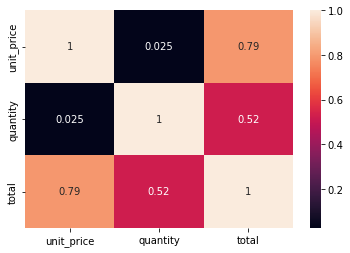

In [43]:
sns.heatmap(df.corr(), annot=True)

In [44]:
numerical_vars

['unit_price', 'quantity', 'total']

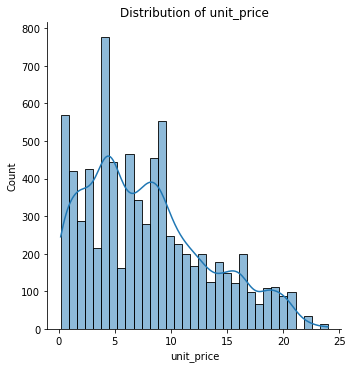

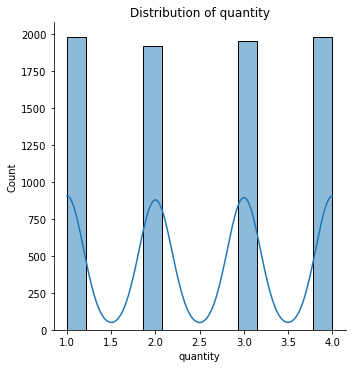

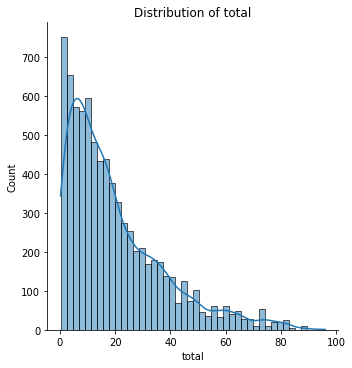

In [45]:
for i in range(len(numerical_vars)):
    plot_continuous_distribution(df,numerical_vars[i])

**Observation**
>- Total price is primary dependent on the unit price.
>- Most of the iteams have unit price below $10. After that count of products for specific unit price start to decrease.
>- Count for quantity is almost constant.
>- As the total price increases, count decreases.

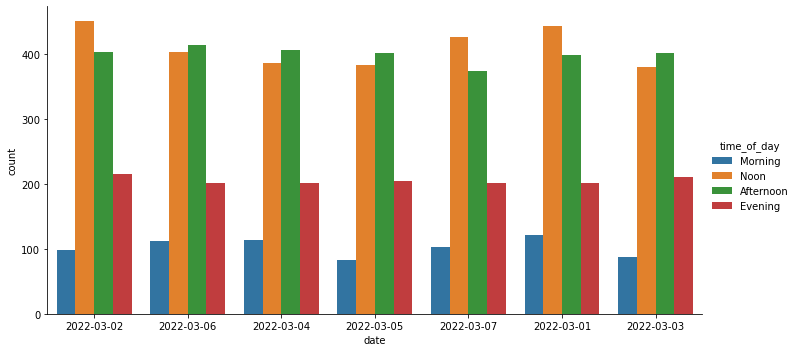

In [46]:
sns.catplot(data=df,x='date',kind='count',hue='time_of_day',aspect=2)

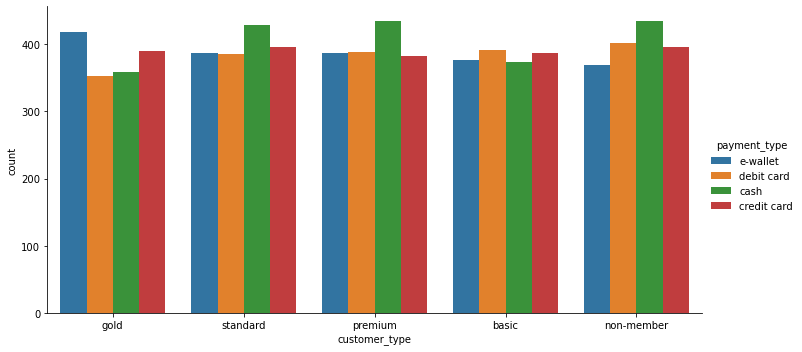

In [47]:
sns.catplot(data=df,x='customer_type',kind='count',hue='payment_type',aspect=2)

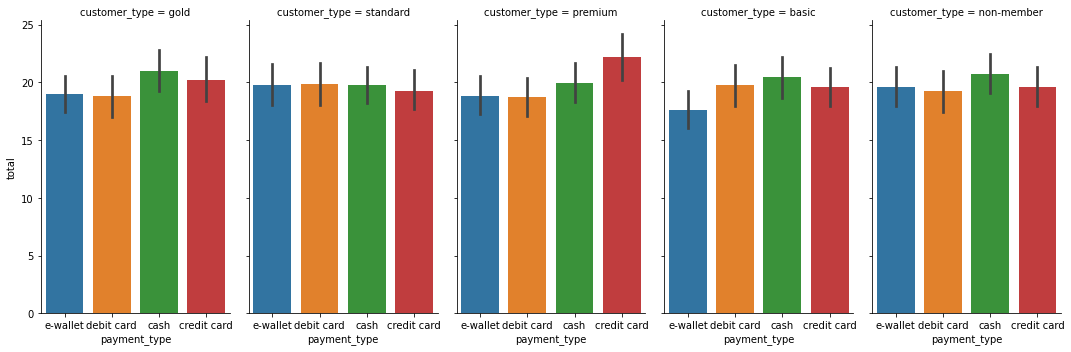

In [48]:
sns.catplot(data=df,
           x='payment_type',
           y='total',
           col='customer_type',
           kind='bar',
           aspect=0.6)

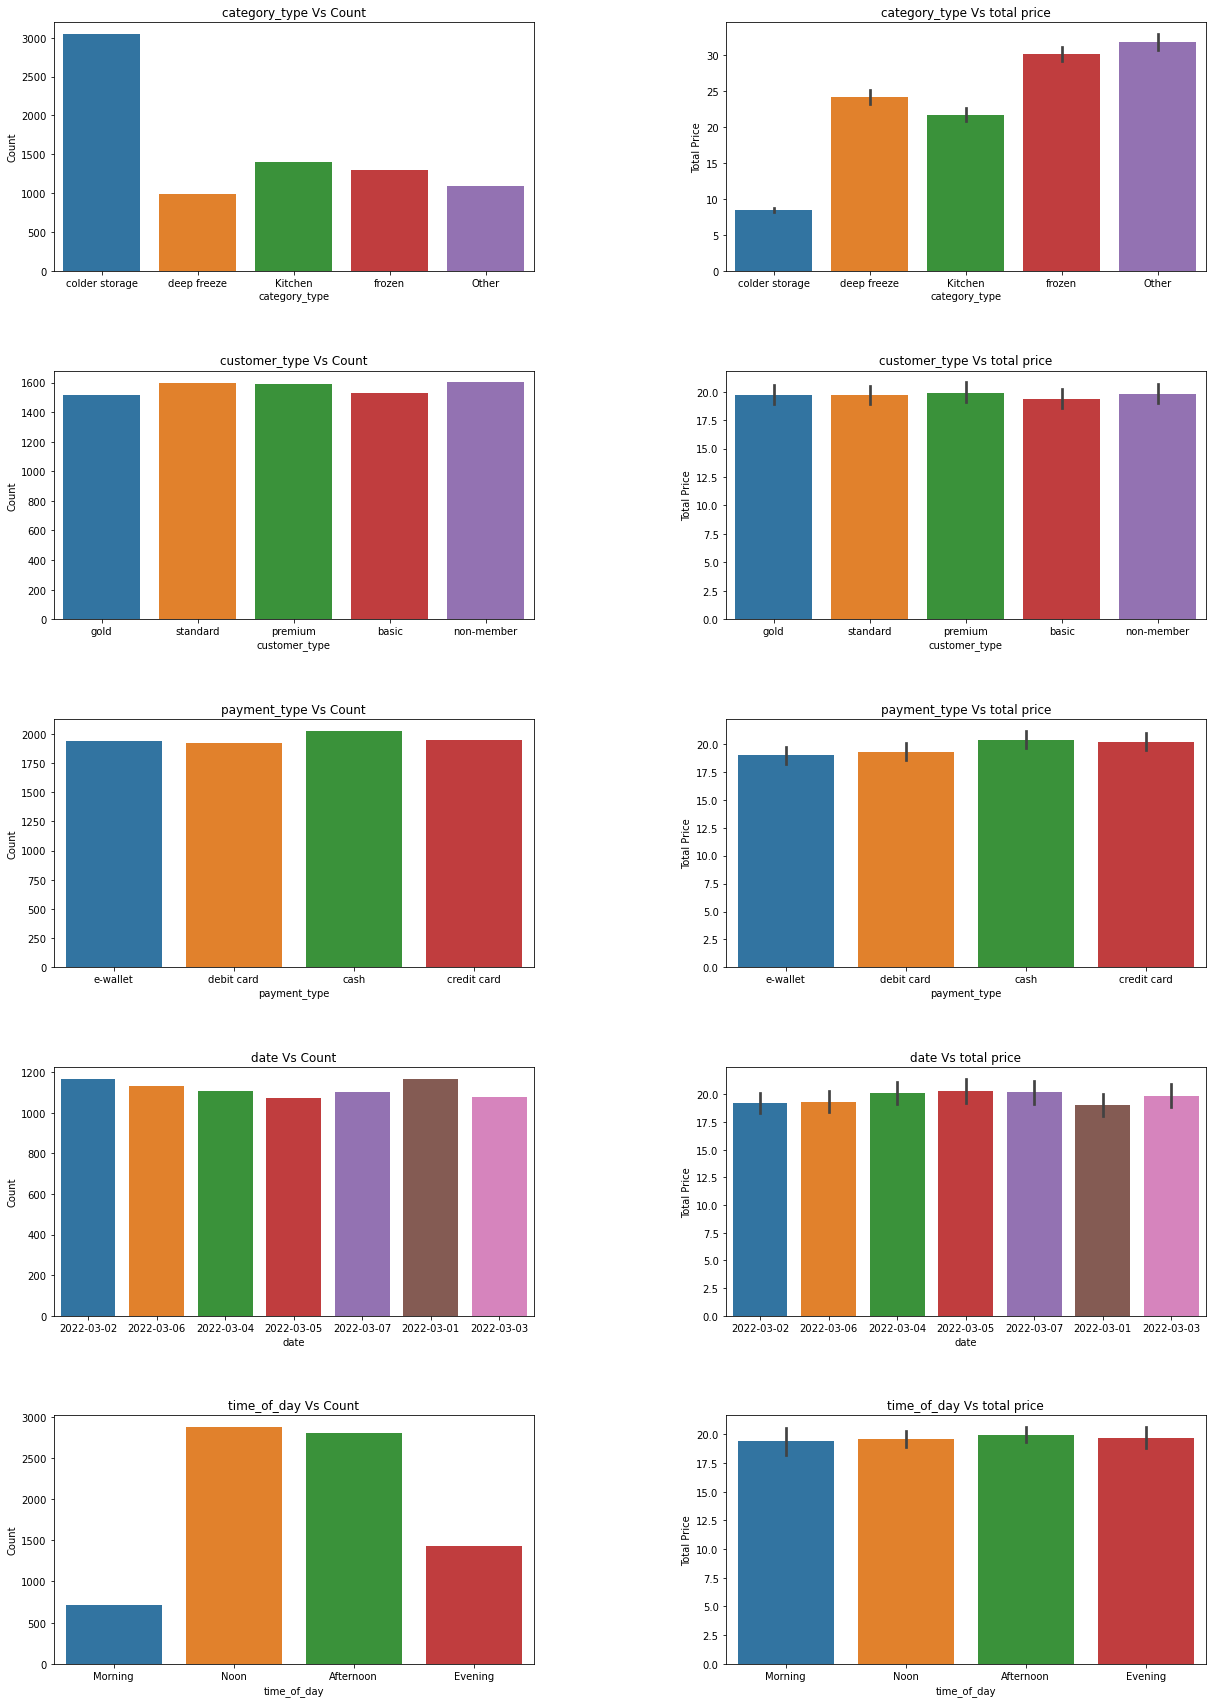

In [49]:
f = plt.figure(figsize=(20,12))
categorical_vars = ['category_type', 'customer_type', 'payment_type','date','time_of_day']
for i, col in enumerate(categorical_vars):
    
    plt.subplot(5, 2, (2*(i+1))-1) # row 1, col 2 index 1
    sns.countplot(data=df, x=col)
    plt.title(col + ' Vs Count')
    plt.xlabel(col)
    plt.ylabel('Count')

    plt.subplot(5, 2, 2*(i+1)) # index 2
    sns.barplot(data=df,
           x=categorical_vars[i],
           y='total')
    plt.title(col + ' Vs total price')
    plt.xlabel(col)
    plt.ylabel('Total Price')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=2.0,
                    wspace=0.4,
                    hspace=0.4)
    
 

In [56]:
df_group_by_category = df.groupby(['category']).agg({'unit_price':'mean', 'quantity':'sum','total':'sum'})

In [59]:
df_group_by_category.sort_values(by=['quantity'],ascending=False)

,unit_price,quantity,total
category,,,
fruit,2.50,2439,6124.21
vegetables,2.37,2124,5070.46
packaged foods,4.92,1280,6373.70
baked goods,7.62,1089,8348.21
canned foods,6.27,1082,6743.48
refrigerated items,6.92,1065,7436.45
kitchen,15.10,955,14456.65
dairy,7.98,950,7551.60
meat,15.01,939,14102.31


**Observations:**

>- Count for colder storage is more but price for it is very less
>- Count for transactions in the morning is less but price is high
>- For other categories count and price are same throughout
>- Gold customers use e-wallet and credit card
>- Non members mainly use cash
>- for premium customer type, majority of total price is paid using credit card
>- Customers of basic type pay least amount of price using ewallet
>- Fruits and vegetables are the most purchased products eventhough they are not highly profitable for Gala Groceries on the other hand products related to kitchen, meat, seafood and medicines are not sold much but they are highly profitable.
>- Spices and herbs, sauces, pet related items are not in demand and dont make much money.

**Conclusion**

>- Need to keep fresh stock of fruits and vegetables.
>- Need to check why spices and herbs are sold in less quantity, is it because the demand is less or is it because they are out of stock?
>- Need few more data points which will answer following questions:
    >>- What all items are purchased by single customer?
    >>- Which items customer was looking for but couldn't puchase as they were out of stock?
    >>- How many items are currently stocked for each product?
    >>- Is the restocking daily, weekly or is it done whenever product goes out of stock?
>- Need more data from multiple stores and for multiple weeks


---

## Section 5 - Summary

We have completed an initial exploratory data analysis on the sample of data provided. We should now have a solid understanding of the data. 

The client wants to know

```
"How to better stock the items that they sell"
```

From this dataset, it is impossible to answer that question. In order to make the next step on this project with the client, it is clear that:

- We need more rows of data. The current sample is only from 1 store and 1 week worth of data
- We need to frame the specific problem statement that we want to solve. The current business problem is too broad, we should narrow down the focus in order to deliver a valuable end product
- We need more features. Based on the problem statement that we move forward with, we need more columns (features) that may help us to understand the outcome that we're solving for

